# Spooky Author Identification
_____

![cat eyes](http://www.sciencealert.com/images/articles/processed/catseyes_1024.jpg)

## Introduction
___
In this year's Kaggle Halloween playground competition, we are being challenged to predict the author of excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft.

## Approach
___
Using libraries such as [string](https://docs.python.org/2/library/string.html), [re](https://docs.python.org/2/library/re.html) and [nltk](http://www.nltk.org), we begin by cleaning the corpus - removing punctuation marks and numbers, converting all letters to lowercase and removing stopwords. 

With the help of visualisation libraries such as [matplotlib](https://matplotlib.org), [seaborn](http://seaborn.pydata.org) and [wordcloud](https://github.com/amueller/word_cloud), we are able to identify the most frequent terms used by the authors in their writing.

We will also use [nltk's inbuilt Part-of-Speech Tagging function](http://www.nltk.org/book/ch05.html) to classify the words into their parts of speech. The reason for doing so is because we might expect authors to use specific tags relatively more than their counterparts. If this is the case, then the POS tags will be a useful tool to identify which author wrote the specific sentence.

We use [sklearn's](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) `CountVectorizer`  to convert the cleaned corpus into a matrix, with each row being a particular document, and each column a particular term. The term counts (how frequent a term appears in the corpus) for a particular document will be the corresponding in the value in the dataframe. Next, we use [sklearn's](http://scikit-learn.org/dev/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) `TfidfVectorizer` to account for the importance of a particular word term - intutively, words that occur frequently in a document (think 'Messi' in a soccer article) but do not frequently occur in the corpus itself tends to be an important term. On the other hand, words that frequently occur in all documents (think 'and', 'if', 'the') are deemed to have relative low importance.

Following the generation of the term frequency dataframe, we conducting Topic Modelling using [gensim](https://radimrehurek.com/gensim/index.html). By identifying the underlying topics within the corpus, we were able to identify the 'hidden' topics within the corpus. Following the identification of such topics, we then allocate topics to each document depending on the terms present in the document.

Finally, we pulled all our features together, and used a simple [Logistic Regression model](https://en.wikipedia.org/wiki/Logistic_regression) using [sklearn's GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to search for the best model by varying the regularisation term, C. On the holdout testing dataset, the preliminary model were able to obtain a testing score of 0.445 (as we are using the metric of logarithmic loss, lower is better). After which, we re-fitted the model, using the best parameters we found (C=10), using the whole training dataset.

## Evaluation Metric
___
Similar to Kaggle's evaluation metric, we will use the [multi-class logarithmic loss](https://www.kaggle.com/c/spooky-author-identification#evaluation).


## Afternote
___
Our model scored 0.42827. The score was good enough to place us at 214 of 584 teams (37th percentile). As it turns out, a simple logistic regression model with good features will outperform a sophisticated machine learning algorithm with poor features. 

In the event that you found this useful, please visit the other kernels that were instrumental in helping me formulate hypotheses, generate new features and challenging some of my beliefs:

1. [Abhishek - Approaching (Almost) Any NLP Problem on Kaggle](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle)
2. [Anisotropic - Spooky NLP and Topic Modelling tutorial](https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial)
3. [Heads or Tails - Treemap House of Horror: Spooky EDA/LDA/Features](https://www.kaggle.com/headsortails/treemap-house-of-horror-spooky-eda-lda-features)

### Importing key libraries and reading dataframe

To facilitate data processing and cleaning, we will import the following libraries:

* [pandas](http://pandas.pydata.org) - pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

* [numpy](http://www.numpy.org) - NumPy is the fundamental package for scientific computing with Python.

* [nltk](http://www.nltk.org) - NLTK is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum.

* [re](https://docs.python.org/2/library/re.html) - This module provides regular expression matching operations similar to those found in Perl. Both patterns and strings to be searched can be Unicode strings as well as 8-bit strings.

* [Matplotlib](https://matplotlib.org) - Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. Matplotlib can be used in Python scripts, the Python and IPython shell, the jupyter notebook, web application servers, and four graphical user interface toolkits.

* [seaborn](http://seaborn.pydata.org) - Seaborn is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.

* [wordcloud](https://github.com/amueller/word_cloud) - Wordcloud is a little word cloud generator in Python.

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

Let's combine the two dataframes.

In [3]:
combined = pd.concat([df_train, df_test]).reset_index(drop=True)

### Exploratory Data Analysis

After reading the dataframes, let's take a look at the first 5 rows of the combined dataframe!

In [4]:
combined.head()

author       id                                               text
0    EAP  id26305  This process, however, afforded me no means of...
1    HPL  id17569  It never once occurred to me that the fumbling...
2    EAP  id11008  In his left hand was a gold snuff box, from wh...
3    MWS  id27763  How lovely is spring As we looked from Windsor...
4    HPL  id12958  Finding nothing else, not even gold, the Super...

In this instance, we have 3 columns:

* author - This is our target label: we are supposed to predict the author from the text.
* id - This is probably a unique identifier that has no correlation with the author.
* text - This is our independent variable/feature to predict the target label, author.

What is the dimension of the dataframe?

In [5]:
print('The training dataset has %d rows and %d columns' % (df_train.shape[0], df_train.shape[1]))
print('The testing dataset has %d rows and %d columns' % (df_test.shape[0], df_test.shape[1]))
print('The combined dataset has %d rows and %d columns' % (combined.shape[0], combined.shape[1]))

The training dataset has 19579 rows and 3 columns
The testing dataset has 8392 rows and 2 columns
The combined dataset has 27971 rows and 3 columns


Are there any missing values? Let's find out.

In [6]:
np.sum(pd.isnull(combined))

author    8392
id           0
text         0
dtype: int64

It appears that there are no NA values in the id and text columns. Also, we note that there are 8,392 missing author values, similar to the number of rows in the testing dataset. Nothing seems to be too alarming here.

How many unique authors are there in the dataset, and how does the author distribution look like?

In [7]:
combined.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

It turns out that there are 3 authors in our dataset, and the author distribution looks to be **quite** uniform.

The authors in the dataset are respectively:

1. **EAP** - Edgar Allen Poe
2. **MWS** - Mary Shelley
3. **HPL** - H.P. Lovecraft

#### Most Common Words

What are the most common words used by the author in this corpus? Let's find out.

In [8]:
import string
import operator
sns.set(font_scale=1.25)

def top_20_words(author):
    # Return a cleaned series of lists of words
    common_words_df = (combined[combined.author == author].text
                       .apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
                       .str.lower()
                       .str.split(' '))
    
    # Returns a dictionary where key = words and values = word counts
    dict_of_word_count = {}
    for text in common_words_df:
        for word in text:
            dict_of_word_count[word] = dict_of_word_count.get(word, 0) + 1

    return sorted(dict_of_word_count.iteritems(), key=lambda(v,k): (k,v), reverse=True)[0:20]

def plot_top_20_words(author):
    plt.figure(figsize=(20, 12))
    topwords = top_20_words(author)
    
    words = zip(*topwords)[0]
    freq = zip(*topwords)[1]
    x_pos = np.arange(len(words)) 
    
    sns.barplot(x_pos, freq)
    plt.xticks(x_pos, words)
    plt.title('Top 20 words of: ' + author)
    plt.show()

##### EAP

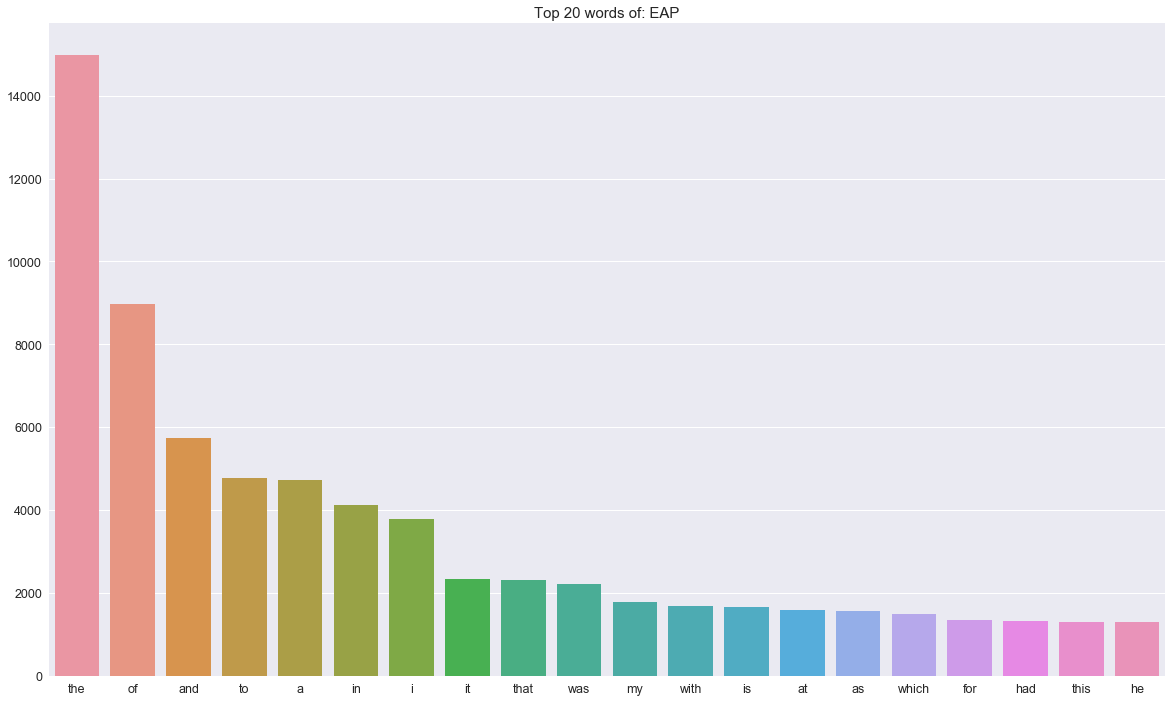

In [9]:
plot_top_20_words('EAP')

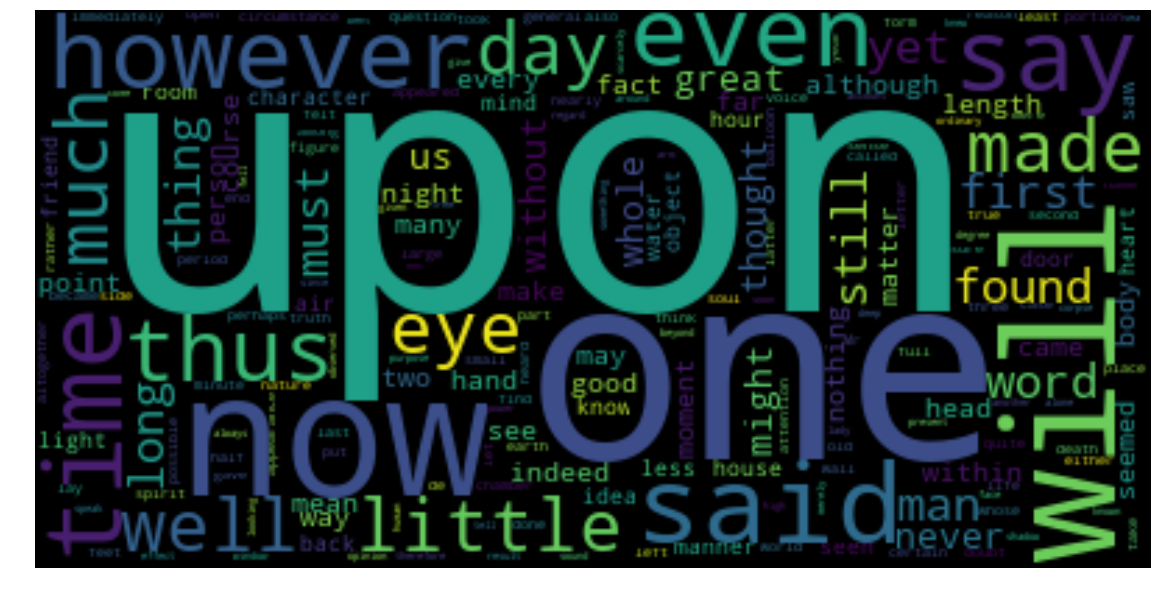

In [10]:
wordcloud = WordCloud().generate(str(combined[combined.author=='EAP'].text.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### HPL

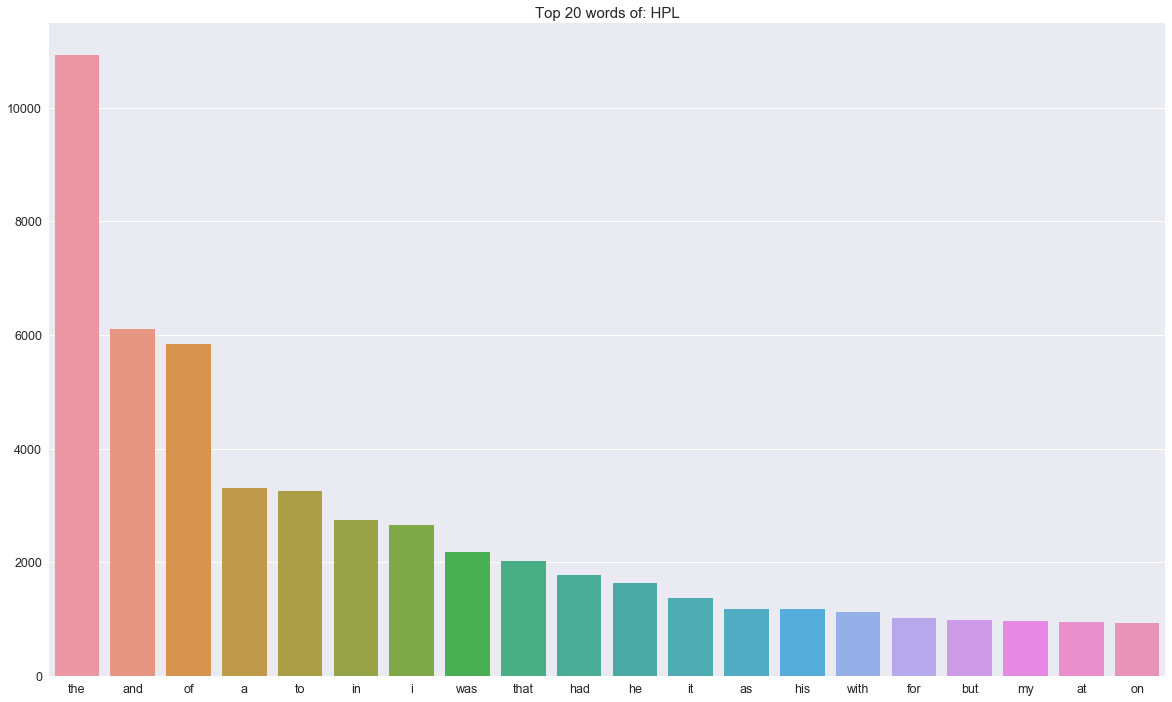

In [11]:
plot_top_20_words('HPL')

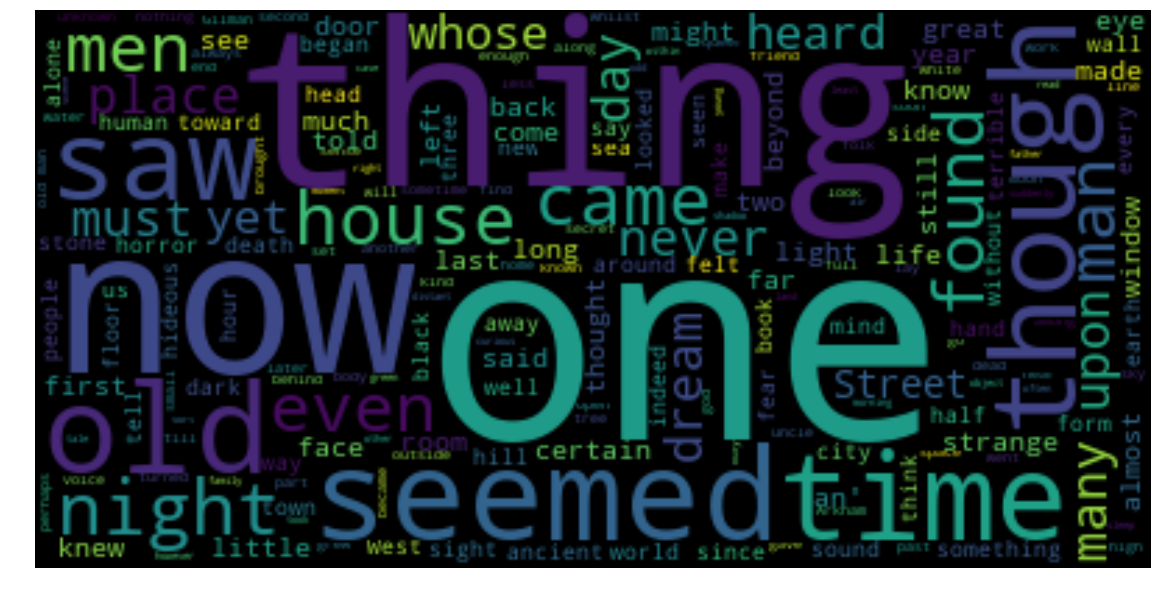

In [12]:
wordcloud = WordCloud().generate(str(combined[combined.author=='HPL'].text.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### MWS

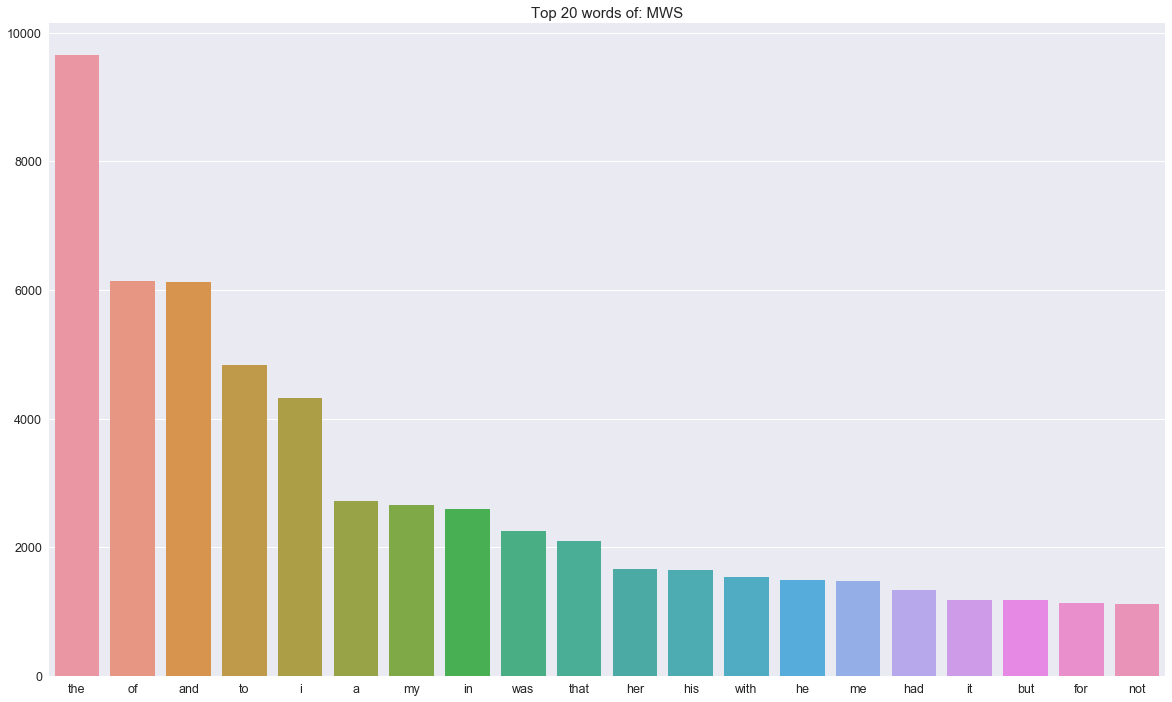

In [13]:
plot_top_20_words('MWS')

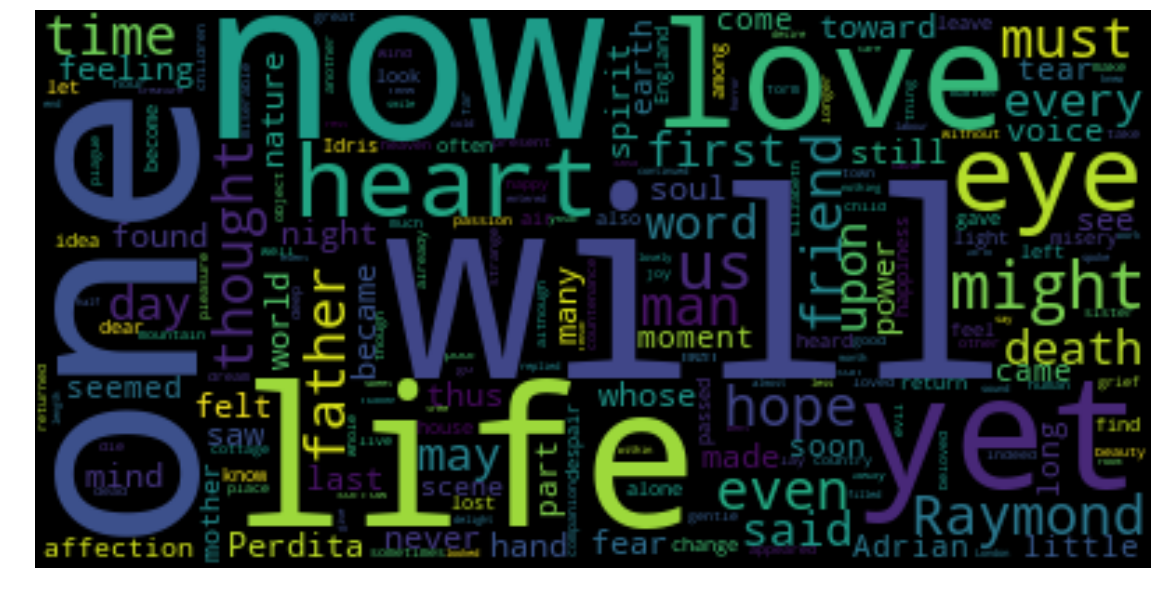

In [14]:
wordcloud = WordCloud().generate(str(combined[combined.author=='MWS'].text.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Judging by the top 20 most common words used by the 3 authors, it appears that they are very similar. Words such as 'the', 'and', 'of', and 'to' and 'a' tend to come up very frequently. It turns out that simply using the most frequency words alone will not help in differentiating across the 3 different authors.

### Feature Engineering with re

Before using the Natural Language ToolKit (NLTK), let's think about some features we can use to predict the author which wrote the text. Here are some examples of features we can generate:

1. Length of sentence - If we believe certain authors tend to be more verbose, then the length of sentence can help us identify these authors better.
2. Number of words - Similar to the length of sentence, this captures the author's verbosity.
3. Number of punctuation marks - If some authors are more likely to use exclaimation marks (!) or apostrophes (') in general, then the number of punctuation marks will be a good feature that we can consider.
4. Number of capital letters - Some authors might use more capital letters in their writing.
5. Average word length - Some authors tend to use longer words compared to their counterparts.

In [15]:
combined['sent_length'] = combined.text.apply(lambda x: len(x))

In [16]:
def word_count(text):
    return len(''.join([word.lower() for word in text if word not in string.punctuation]).split(' '))

combined['word_length'] = combined.text.apply(word_count)

In [17]:
combined['punc_marks'] = (combined
                          .text
                          .apply(lambda x: 
                                 len(re.findall('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', x))) /
                          combined.sent_length)

In [18]:
combined['cap_letter'] = (combined
                          .text
                          .apply(lambda x: 
                                 len(re.findall('[A-Z]', x))) /
                          combined.sent_length)

In [19]:
combined['avg_word_length'] = combined.sent_length / combined.word_length

After the creation of these features, let's take a look at their distributions according to the 3 authors!

##### Sentence Length

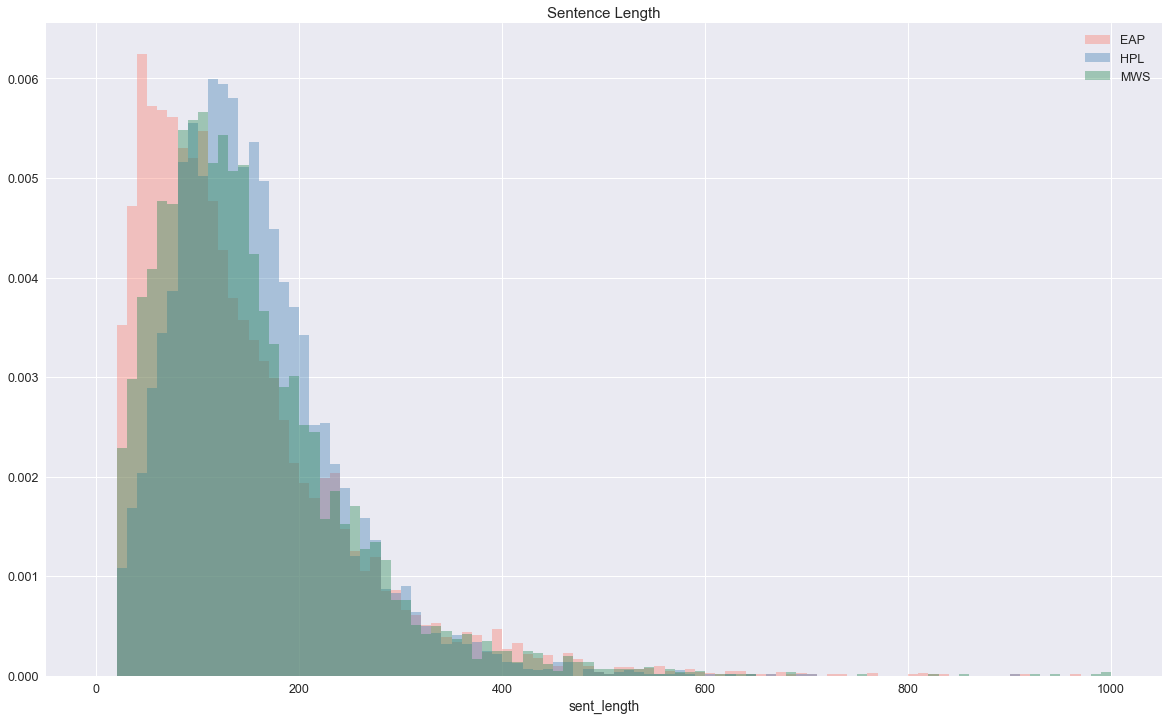

In [20]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].sent_length, color = 'salmon', 
             bins=np.linspace(0, 1000, 101), kde=False, norm_hist=True, label = 'EAP')
sns.distplot(combined[combined.author == 'HPL'].sent_length, color = 'steelblue', 
             bins=np.linspace(0, 1000, 101), kde=False, norm_hist=True, label = 'HPL')
sns.distplot(combined[combined.author == 'MWS'].sent_length, color = 'seagreen', 
             bins=np.linspace(0, 1000, 101), kde=False, norm_hist=True, label = 'MWS')

plt.title('Sentence Length')
plt.legend()
plt.show()

On average, the 3 authors tend to write sentences of equal length (about 200 - 300 characters). We do note that the author, Lovecraft writes relatively long sentences, while Poe writes relatively short sentences. 

##### Word Length

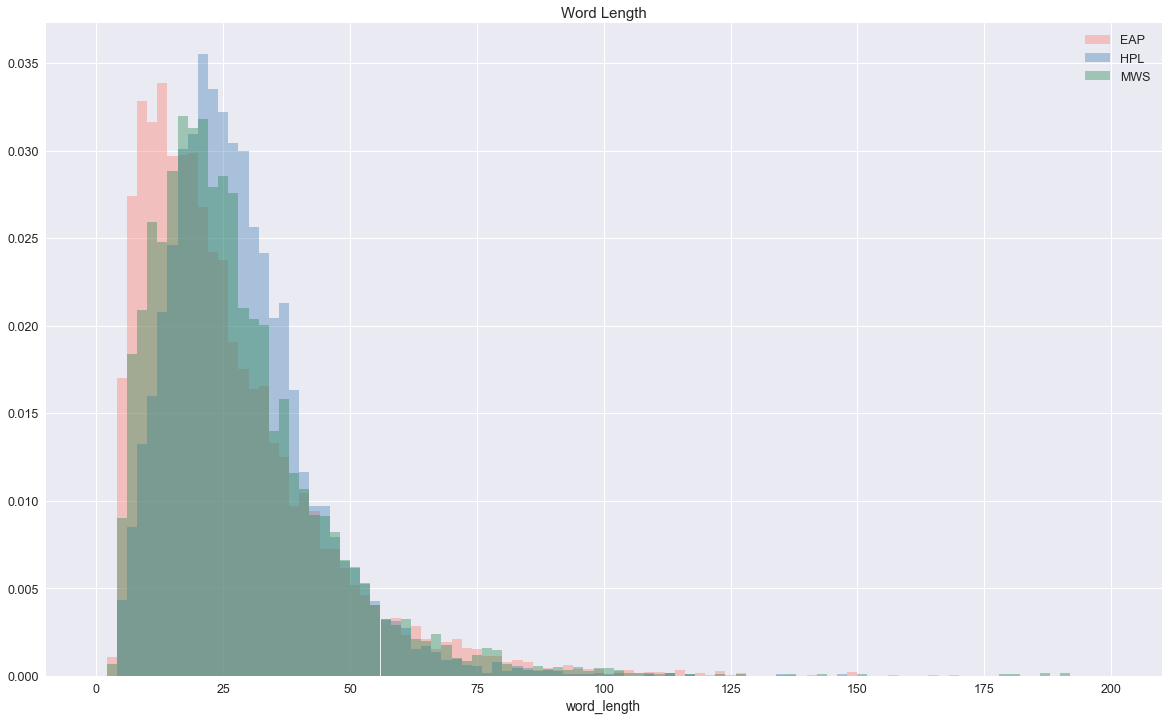

In [21]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].word_length, color = 'salmon',
             bins=np.linspace(0, 200, 101), kde=False, norm_hist=True, label = 'EAP')
sns.distplot(combined[combined.author == 'HPL'].word_length, color = 'steelblue', 
             bins=np.linspace(0, 200, 101), kde=False, norm_hist=True, label = 'HPL')
sns.distplot(combined[combined.author == 'MWS'].word_length, color = 'seagreen', 
             bins=np.linspace(0, 200, 101), kde=False, norm_hist=True, label = 'MWS')

plt.title('Word Length')
plt.legend()
plt.show()

The word length feature appears to be strongly correlated with the sentence length feature. This isn't surprisingly at all. (**Why?**)

##### Number of Punctuations

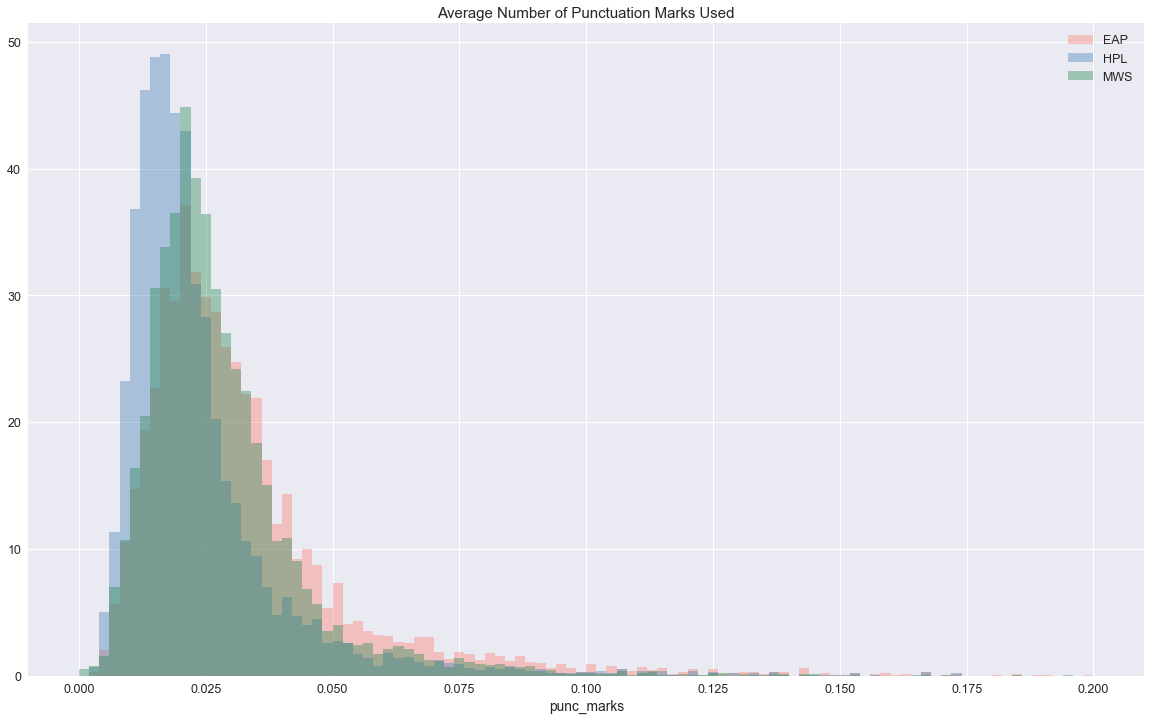

In [22]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].punc_marks, color='salmon', label = 'EAP',
             bins = np.linspace(0, 0.2, 101), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'HPL'].punc_marks, color='steelblue', label = 'HPL',
             bins = np.linspace(0, 0.2, 101), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'MWS'].punc_marks, color='seagreen', label = 'MWS',
             bins = np.linspace(0, 0.2, 101), kde=False, norm_hist=True)
plt.title("Average Number of Punctuation Marks Used")
plt.legend()

plt.show()

As it turns out, the number of punctuation marks used appears to be quite good at separating between the 3 authors. We note that the Poe and Shelley tend to use more punctuation marks in their sentence (controlled for the number of words), compared to Lovecraft.

##### Number of Capital Letters

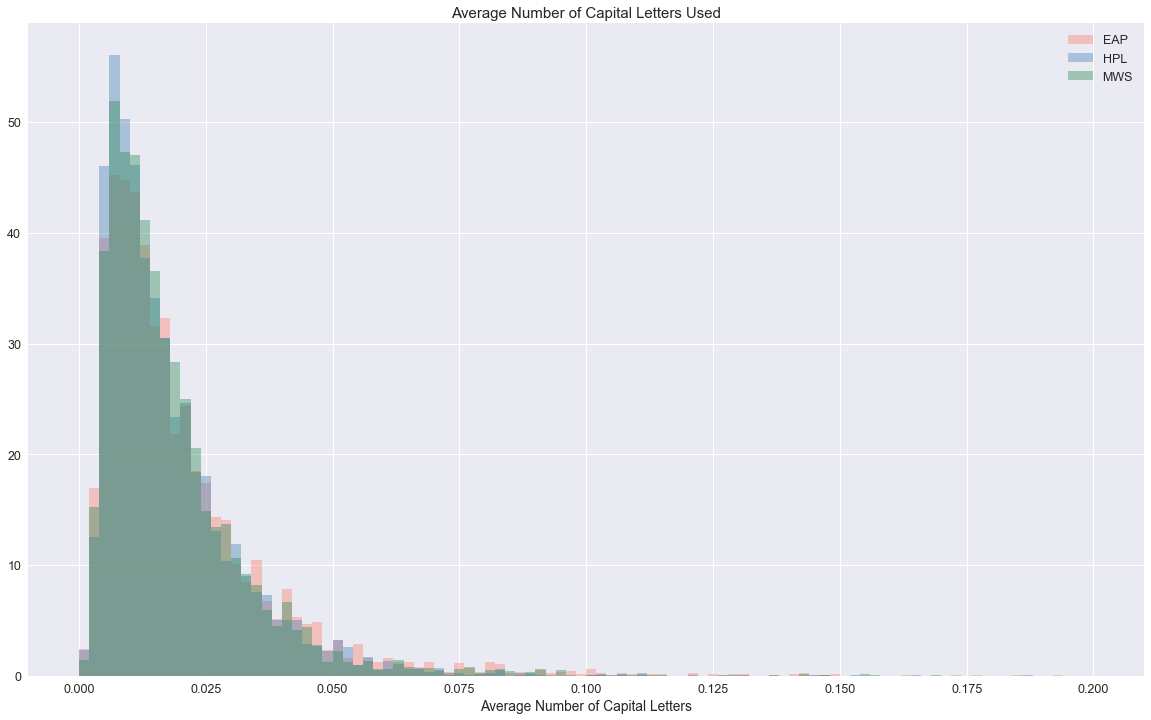

In [23]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].cap_letter, color='salmon', label = 'EAP',
             bins = np.linspace(0, 0.2, 101), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'HPL'].cap_letter, color='steelblue', label = 'HPL',
             bins = np.linspace(0, 0.2, 101), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'MWS'].cap_letter, color='seagreen', label = 'MWS',
             bins = np.linspace(0, 0.2, 101), kde=False, norm_hist=True)
plt.title("Average Number of Capital Letters Used")
plt.xlabel('Average Number of Capital Letters')
plt.legend()

plt.show()

On average, the number of capital letters used in a sentence doesn't seem to be terribly informative of the target label. We do note that on average, all 3 authors use similar amounts of capital letters.

##### Average Word Length

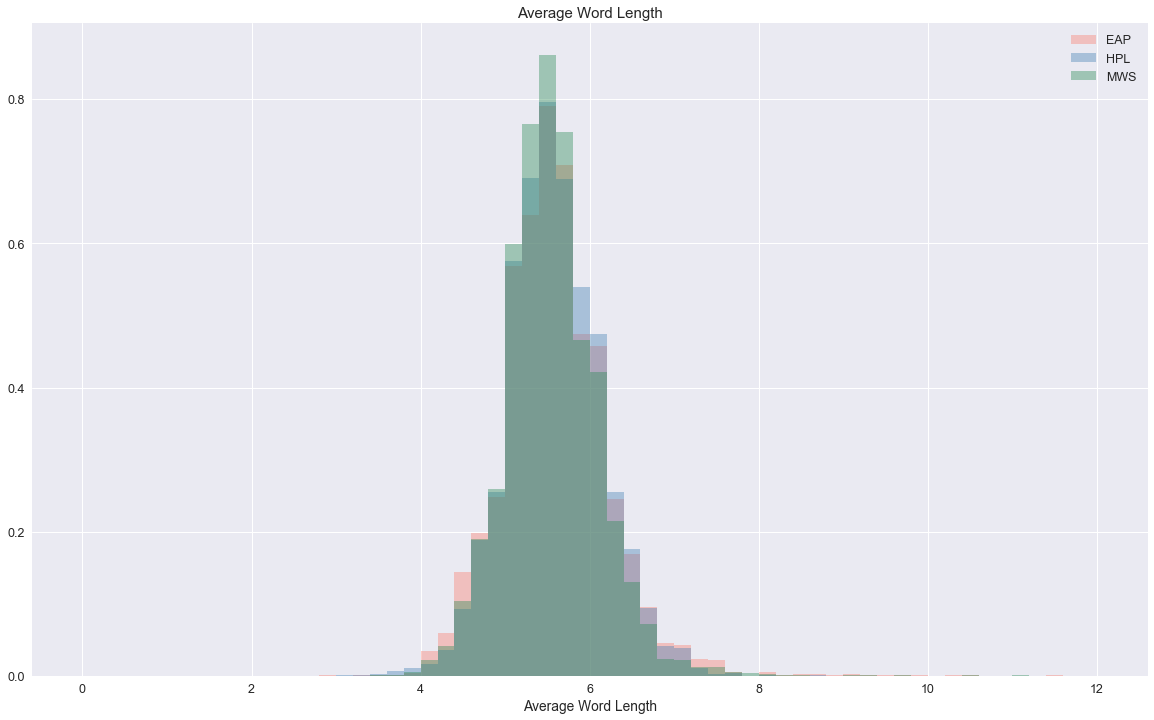

In [24]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].avg_word_length, color='salmon', label = 'EAP',
             bins = np.linspace(0, 12, 61), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'HPL'].avg_word_length, color='steelblue', label = 'HPL',
             bins = np.linspace(0, 12, 61), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'MWS'].avg_word_length, color='seagreen', label = 'MWS',
             bins = np.linspace(0, 12, 61), kde=False, norm_hist=True)
plt.title("Average Word Length")
plt.xlabel('Average Word Length')
plt.legend()

plt.show()

On average, we note that the average word length across the 3 authors don't seem to deviate too much. Most of the words fall between 4 to 8 characters.

### Feature Engineering with NLTK

Let's use the Natural Language Toolkit library in Python to generate more features!

#### Stopwords Stemming

First, we remove punctuations from the text column of our combined dataframe, and convert capital letters into small letters. After which, we remove stopwords from the cleaned text and *lemmatize* the cleaned text using NLTK's inbuilt `WordNetLemmatizer`. In addition, we will also conduct word stemming using NLTK's inbuilt `PorterStemmer`.

In [25]:
# Cleaning text - removing punctuation, and converting capital letters to small letters
def list_of_words(text):
    return ''.join([word.lower() for word in text if word not in string.punctuation]).split(' ')

wordlist = combined.text.apply(list_of_words)

In [26]:
# Cleaning text - removing non-alphanumeric characters
def remove_spaces(text):
    return ' '.join([re.sub('[^a-zA-Z0-9]', ' ', word) for word in text]).split(' ')

wordlist = wordlist.apply(remove_spaces)

In [27]:
# Removing stopwords from the list of words - warning: takes a long time 
from nltk.corpus import stopwords

def list_of_nonstopwords(text):
    return [word for word in text if word.decode('utf-8') not in stopwords.words('english')]

nonstopword_list = wordlist.apply(list_of_nonstopwords)

In [28]:
# Lemmatizing the list of non-stop-words
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatized_words(text):
    return ' '.join([lemmatizer.lemmatize(word.decode('utf-8')) for word in text])

combined['lemmatized_words'] = nonstopword_list.apply(lemmatized_words)

In [29]:
# Stemming the list of non-stop-words
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemmed_words(text):
    return ' '.join([stemmer.stem(word.decode('utf-8')) for word in text])

combined['stemmed_words'] = nonstopword_list.apply(stemmed_words)

Let's take a look at the first 5 rows of our dataframe.

In [30]:
combined.head()

author       id                                               text  \
0    EAP  id26305  This process, however, afforded me no means of...   
1    HPL  id17569  It never once occurred to me that the fumbling...   
2    EAP  id11008  In his left hand was a gold snuff box, from wh...   
3    MWS  id27763  How lovely is spring As we looked from Windsor...   
4    HPL  id12958  Finding nothing else, not even gold, the Super...   

   sent_length  word_length  punc_marks  cap_letter  avg_word_length  \
0          231           41    0.030303    0.012987         5.634146   
1           71           14    0.014085    0.014085         5.071429   
2          200           36    0.025000    0.005000         5.555556   
3          206           34    0.019417    0.019417         6.058824   
4          174           27    0.022989    0.011494         6.444444   

                                    lemmatized_words  \
0  process however afforded mean ascertaining dim...   
1         never occurred fumbling might mere mistake   
2  left hand gold snuff box capered hill cutting ...   
3  lovely spring looked windsor terrace sixteen f...   
4  finding nothing else even gold superintendent ...   

                                       stemmed_words  
0  process howev afford mean ascertain dimens dun...  
1                never occur fumbl might mere mistak  
2  left hand gold snuff box caper hill cut manner...  
3  love spring look windsor terrac sixteen fertil...  
4  find noth els even gold superintend abandon at...

#### Most Common Lemmatized Words

After using WordNetLemmatizer to lemmatize the text in the combined dataframe, let's take a look at the most common lemmatized terms.

In [31]:
def top_20_words_lemmatized(author):
    # Return a cleaned series of lists of words
    author_stemmed = (combined[combined.author == author].lemmatized_words
                      .apply(lambda text: ''.join([word for word in text])).str.split(' '))

    # Returns a dictionary where key = words and values = word counts
    dict_of_word_count = {}
    for text in author_stemmed:
        for word in text: dict_of_word_count[word] = dict_of_word_count.get(word, 0) + 1

    return sorted(dict_of_word_count.iteritems(), key=lambda(v,k): (k,v), reverse=True)[0:20]

def plot_top_20_words_lemmatized(author):
    plt.figure(figsize=(20, 12))
    topwords = top_20_words_lemmatized(author)
    
    words, freq = zip(*topwords)[0], zip(*topwords)[1]
    
    x_pos = np.arange(len(words)) 
    sns.barplot(x_pos, freq)
    plt.xticks(x_pos, words)
    plt.title('Top 20 lemmatized_words terms of: ' + author)
    plt.show()

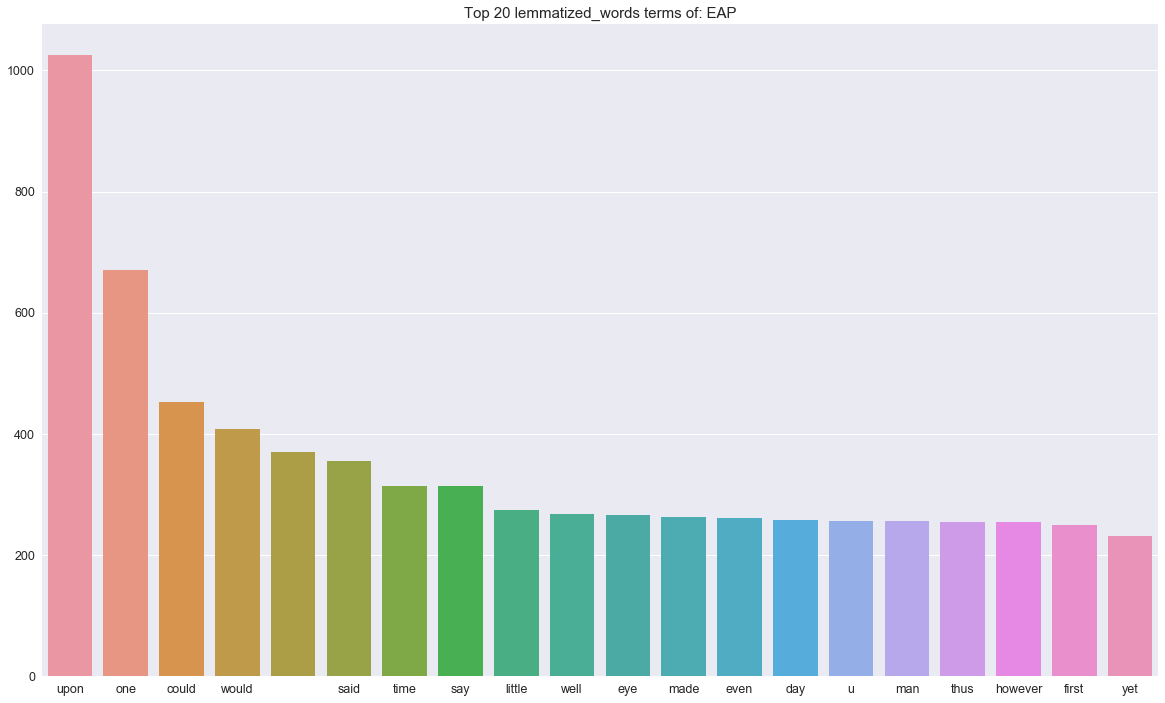

In [32]:
# Plotting top lemmatized words for Edgar Allen Poe
plot_top_20_words_lemmatized('EAP')

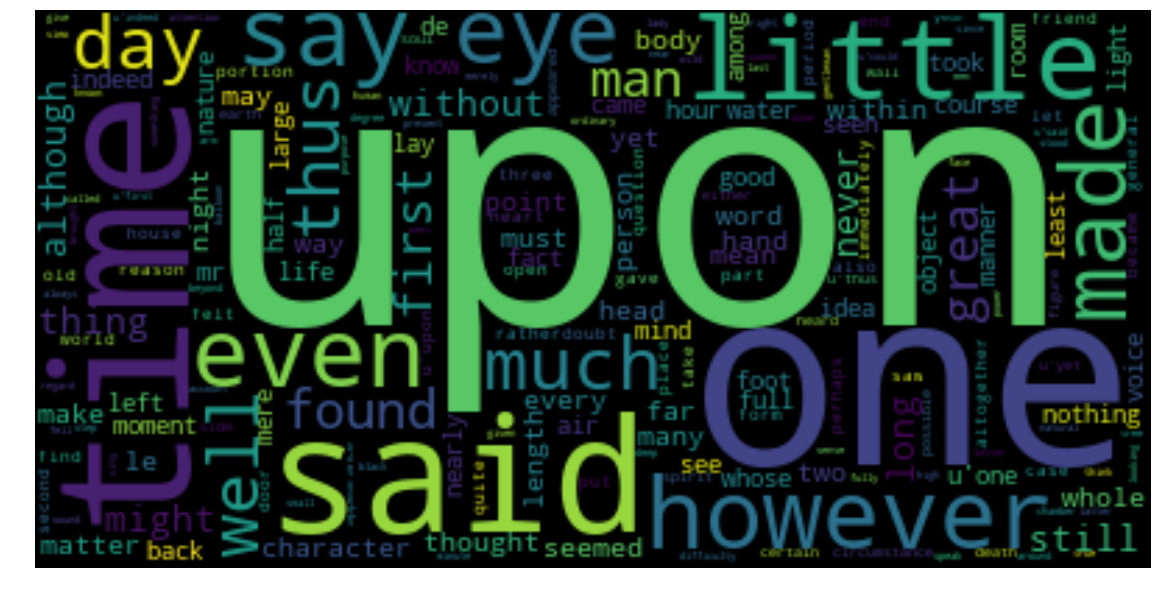

In [33]:
wordcloud = WordCloud().generate(str(combined[combined.author=='EAP'].lemmatized_words.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

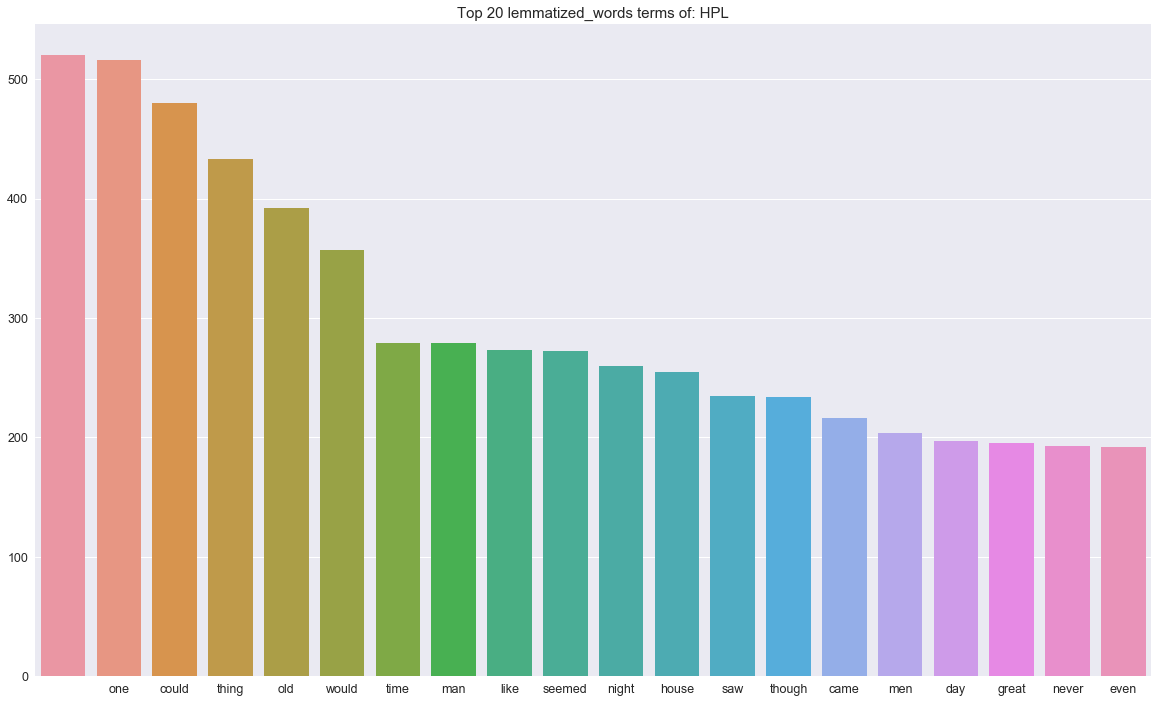

In [34]:
# Plotting top lemmatized words for H.P. Lovecraft
plot_top_20_words_lemmatized('HPL')

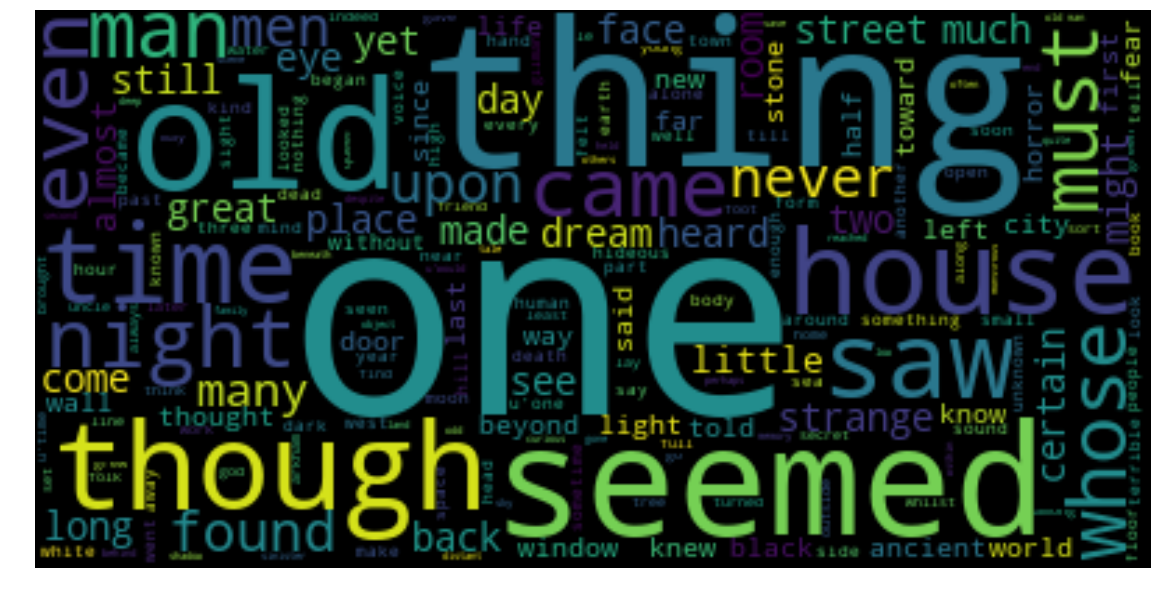

In [35]:
wordcloud = WordCloud().generate(str(combined[combined.author=='HPL'].lemmatized_words.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

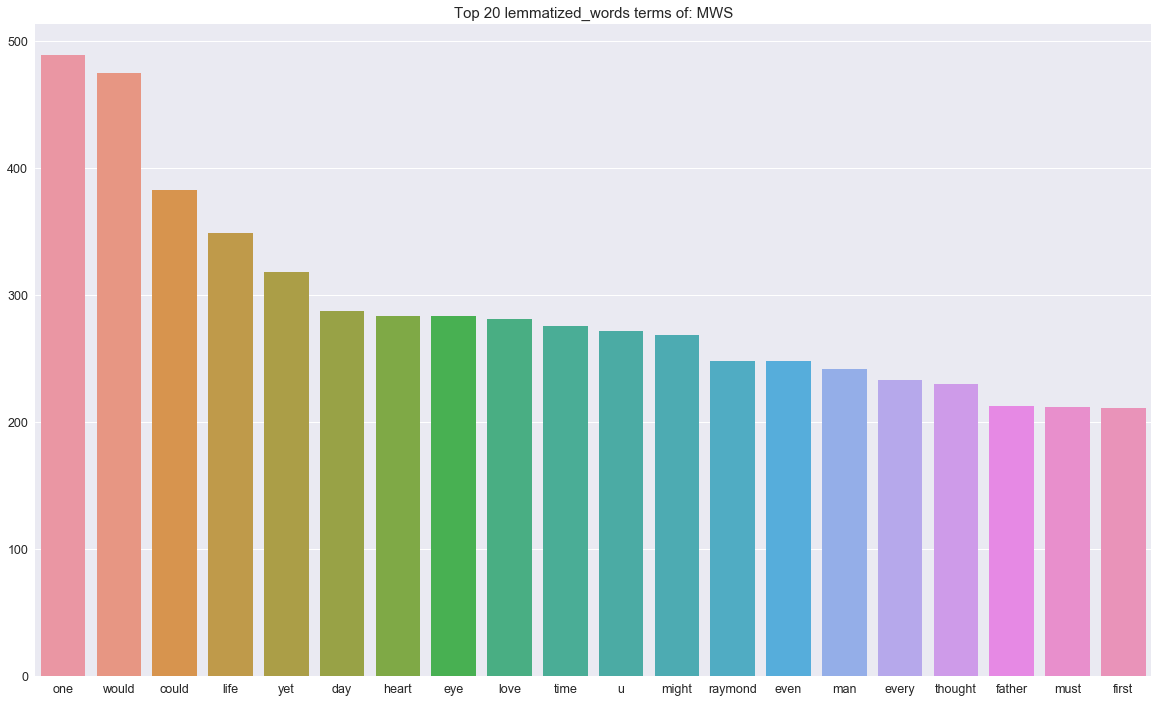

In [36]:
# Plotting top lemmatized words for Mary Shelley
plot_top_20_words_lemmatized('MWS')

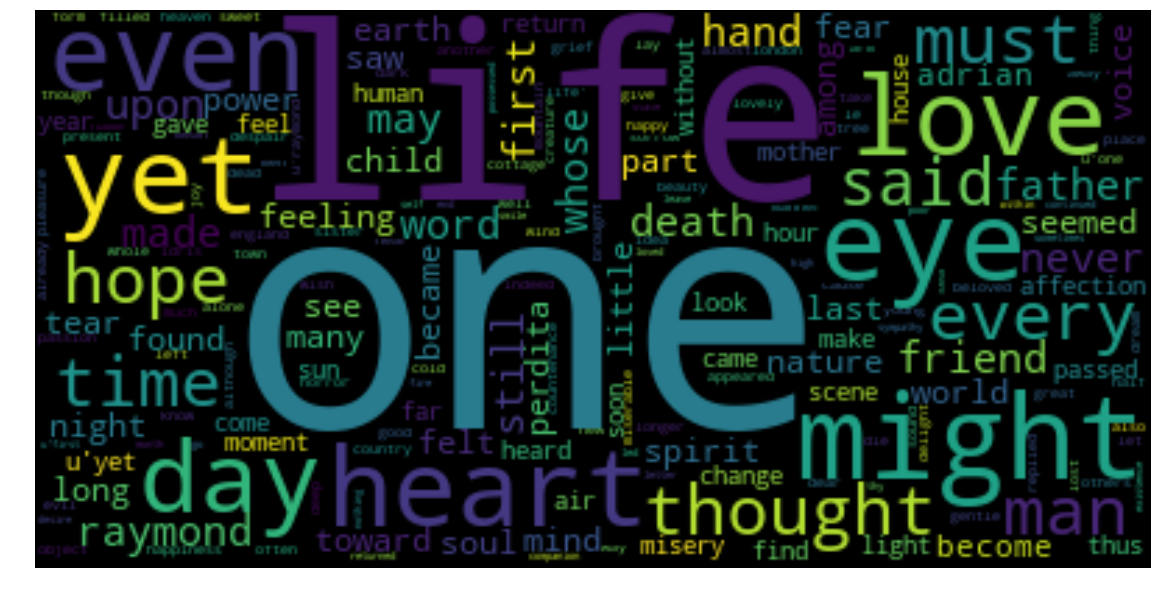

In [37]:
wordcloud = WordCloud().generate(str(combined[combined.author=='MWS'].lemmatized_words.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

After removing stopwords and conducting lemmatizing the cleaned dataframe on our dataframe, there are still many common words, such as 'one' and 'seemed'. As these words frequently occur in the corpus, they are not "good" indicators of the authors.

#### Part-of-Speech Tagging

According to NLTK, part-of-speech tagging, or POS-tagging is the process of classifying words into their parts of speech and labeling them accordingly. Parts of speech are also known as word classes or lexical categories. The collection of tags used for a particular task is known as a tagset.

For our analysis, we can look at the number of nouns, verbs and adjectives in each sentence, and potentially use them as features. Intuitively, the writing style differs from authors to authors. We would expect certain authors to use more nouns, verbs or adjectives relative to other authors. Let's make use of this observation to create more features.

In [38]:
# Conduct POS Tagging (takes a bit of time to run this code)
pos_tags = (combined.text.apply(lambda text: nltk.pos_tag(nltk.word_tokenize(text.decode('utf-8')))))

In [39]:
def pos_tag_count(list_of_postag):
    # Return dictionary of dataframes with postags as keys and counts as values
    dict_of_postags = {}
    for tag in list_of_postag:
        dict_of_postags[tag[1]] = dict_of_postags.get(tag[1], 0) + 1
    return dict_of_postags
        
postags_df = pd.DataFrame(pos_tags.apply(pos_tag_count).to_dict()).T

Let's remove the punctuations from the POS Tagging dataframe, as they should not be very informative of the target label.

In [40]:
pos_tag_col = [col for col in postags_df.columns if re.findall('[A-Z]+', col)]

postags_df_ = postags_df[pos_tag_col].fillna(0)

To check which tags are most indicative of the target label, we can use a correlation matrix to estimate their importance.

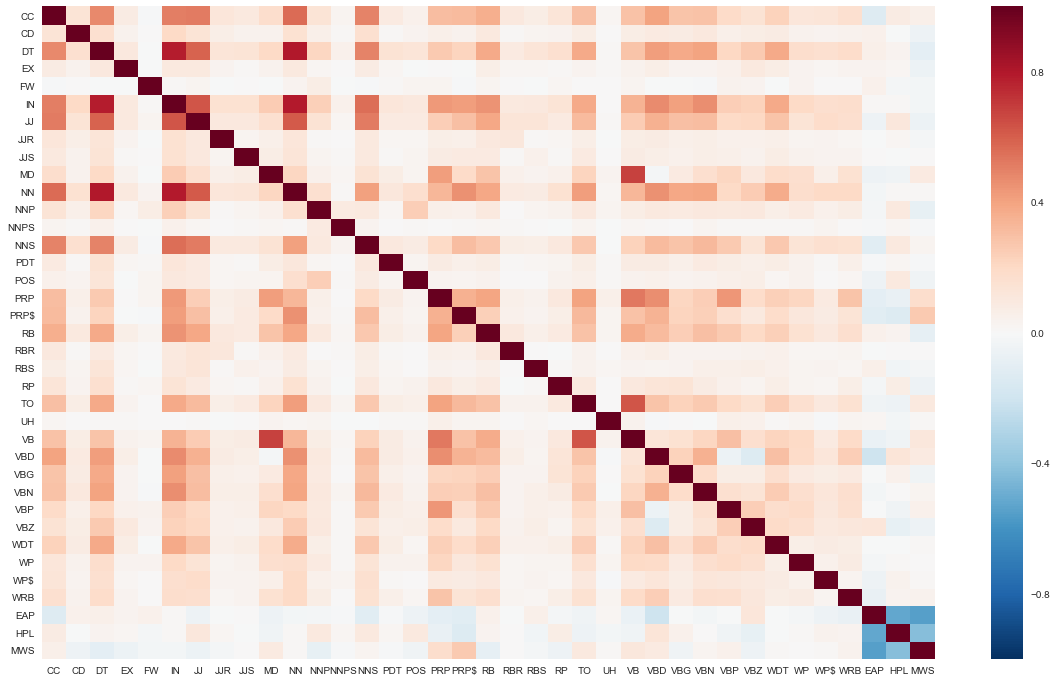

In [41]:
postags_df_['EAP'] = pd.get_dummies(df_train.author).EAP
postags_df_['HPL'] = pd.get_dummies(df_train.author).HPL
postags_df_['MWS'] = pd.get_dummies(df_train.author).MWS

sns.set(font_scale=1)
plt.figure(figsize=(20,12))
sns.heatmap(postags_df_.corr())
plt.show()

Let's include these features in our model!

In [42]:
del postags_df_['EAP']
del postags_df_['HPL']
del postags_df_['MWS']

combined = pd.merge(combined, postags_df_,
                    left_index=True, right_index=True)

### Feature Engineering with Scikit-Learn

After we have engineered features with re and NLTK, let's try to generate more features using Scikit-Learn! We can use the CountVectorizer to find words that occur a minimum amount of times in the dataframe. In our case, we will only focus only on unigrams, bigramS, trigrams... and 10-grams, which occur at least 3 times.

In [43]:
X_train = combined.iloc[:df_train.shape[0]]
X_test = combined.iloc[df_train.shape[0]:]

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

# Use CountVectorizor to remove stop_words, remove tokens that don't appear in at least 3 documents,
# and remove tokens that appear in more than 10% of the documents
vect = CountVectorizer(min_df=3, ngram_range=(1, 10))

train_counts_transformed = vect.fit_transform(X_train.stemmed_words)
test_counts_transformed = vect.transform(X_test.stemmed_words)

Let's take a quick look at the dimensions of our dataframe.

In [45]:
train_counts_transformed

<19579x14701 sparse matrix of type '<type 'numpy.int64'>'
	with 267909 stored elements in Compressed Sparse Row format>

After vectorizing the n-gram counts, let's use the TfidfTransformer to convert our bag of words! Basically, the [tf-idf](https://en.wikipedia.org/wiki/Tf–idf) (term frequency-inverse document freqency) is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. 

Intuitively, you would expect relatively important words to occur frequently within a specific text, but does not appear frequently across the corpus. Think of the words 'Sherlock' and 'Holmes' - these words shouldn't occur in many different texts! On the other hand, words such as 'and', 'the' and 'of' appears frequently occur in many different texts, and are unimportant.

In [46]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True)

train_tfidf = tfidf.fit_transform(train_counts_transformed)
test_tfidf = tfidf.transform(test_counts_transformed)

As it turns out, 14701 features fit the bill. Let's merge the dataframes together.

In [47]:
X_train_ = pd.merge(X_train, pd.DataFrame(train_tfidf.toarray()),
                    left_index=True, right_index=True)

X_test_ = pd.merge(X_test.reset_index(drop=True), pd.DataFrame(test_tfidf.toarray()), 
                   left_index=True, right_index=True)

### Topic Modelling with Gensim

After feature engineering, let's conduct topic modelling to identify potential topics in the corpus! Intuitively, certain authors tend to write about certain topics - things which are closer to their hearts. 

Hence, the identification of such topics could potentially help to improve our prediction rates.

Let's proceed to train our models using the cleaned corpus.

In [48]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=3, ngram_range=(1,5), stop_words='english')

# Fit and transform
text_train = vect.fit_transform(X_train.lemmatized_words)

# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(text_train, documents_columns=False)

# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in vect.vocabulary_.items())

Using TensorFlow backend.


In order to carry out Topic Modelling, we have to impute a parameter, $k$, which tells gensim the number of topics in the corpus. In our case, we settle on 6 different topics. In addition, let's set a random seed to ensure that the analysis is reproducible.

In [49]:
# Use the gensim.models.ldamodel.LdaModel constructor to estimate 
# LDA model parameters on the corpus, and save to the variable `ldamodel`

random_state = 9410

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 6,
                                           id2word = id_map, passes = 6,
                                           random_state = random_state)

What are these topics?

In [50]:
ldamodel.show_topics(num_topics=6)

[(0,
  u'0.013*"said" + 0.009*"love" + 0.008*"life" + 0.007*"heart" + 0.006*"day" + 0.006*"father" + 0.006*"hope" + 0.006*"friend" + 0.006*"word" + 0.005*"raymond"'),
 (1,
  u'0.008*"door" + 0.005*"eye" + 0.005*"room" + 0.005*"water" + 0.005*"open" + 0.004*"hand" + 0.004*"window" + 0.004*"street" + 0.004*"wall" + 0.004*"foot"'),
 (2,
  u'0.006*"eye" + 0.005*"voice" + 0.005*"man" + 0.004*"mother" + 0.004*"half" + 0.004*"face" + 0.004*"human" + 0.004*"death" + 0.003*"heard" + 0.003*"away"'),
 (3,
  u'0.005*"say" + 0.004*"word" + 0.004*"time" + 0.004*"great" + 0.004*"mr" + 0.004*"day" + 0.003*"question" + 0.003*"place" + 0.003*"taken" + 0.003*"fact"'),
 (4,
  u'0.010*"old" + 0.007*"thing" + 0.007*"man" + 0.007*"night" + 0.006*"like" + 0.005*"saw" + 0.004*"house" + 0.004*"day" + 0.003*"seen" + 0.003*"near"'),
 (5,
  u'0.008*"time" + 0.007*"long" + 0.006*"life" + 0.006*"like" + 0.005*"thing" + 0.005*"year" + 0.004*"shall" + 0.004*"say" + 0.004*"day" + 0.004*"sea"')]

Let's write a function that returns the most likely topic, given the text.

In [51]:
def most_probable_topic(text):
    
    # Transform text into Corpus
    X = vect.transform(text)
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    
    # Return topic distribution
    topic_dist =  ldamodel.inference(corpus)[0]
    
    topics = [max(enumerate(corpus), key=operator.itemgetter(1))[0] for corpus in topic_dist]
    
    return topics

Now that we have obtained the topic numbers, let's convert the topics found using One-Hot Encoding. We can use pandas' inbuilt function `pd.get_dummies()` to do so.

In [52]:
train_topics = pd.get_dummies(most_probable_topic(X_train.lemmatized_words), prefix='topic')
test_topics = pd.get_dummies(most_probable_topic(X_test.lemmatized_words), prefix='topic')

In [53]:
train_topics.head()

topic_0  topic_1  topic_2  topic_3  topic_4  topic_5
0        0        1        0        0        0        0
1        0        0        0        1        0        0
2        0        1        0        0        0        0
3        0        0        0        1        0        0
4        0        1        0        0        0        0

In [54]:
X_train = pd.merge(X_train_, train_topics, left_index=True, right_index=True)
X_test = pd.merge(X_test_, test_topics, left_index=True, right_index=True)

What are the dimensions of our training and testing dataframe? Let's take a look.

In [55]:
print 'Training Dimension: ', X_train.shape
print 'Testing Dimension: ', X_test.shape

Training Dimension:  (19579, 14751)
Testing Dimension:  (8392, 14751)


#### Distribution of Topic Numbers according to the different Authors

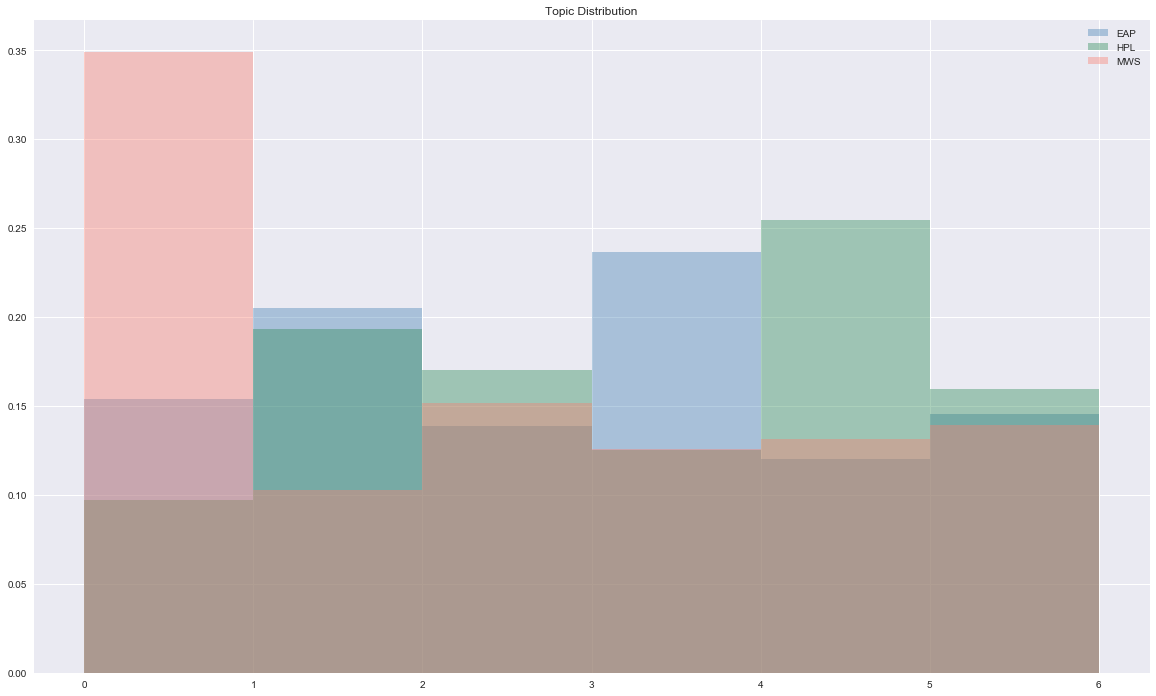

In [56]:
plt.figure(figsize=(20,12))

topics = pd.DataFrame(most_probable_topic(X_train.lemmatized_words))

sns.distplot(topics.iloc[combined[combined.author=='EAP'].index.values],
             bins=range(0, 7, 1), kde=False, norm_hist=True, color='steelblue', label='EAP')
sns.distplot(topics.iloc[combined[combined.author=='HPL'].index.values],
             bins=range(0, 7, 1), kde=False, norm_hist=True, color='seagreen', label='HPL')
sns.distplot(topics.iloc[combined[combined.author=='MWS'].index.values],
             bins=range(0, 7, 1), kde=False, norm_hist=True, color='salmon', label='MWS')

plt.title('Topic Distribution')
plt.legend()
plt.show()

### Model Fitting

Let's select the features which we will be using for our prediction.

In [57]:
from sklearn.model_selection import train_test_split

X_train.columns = [str(feat) for feat in X_train.columns.tolist()]
X_test.columns = [str(feat) for feat in X_test.columns.tolist()]
features = [feat for feat in X_train.columns.tolist() 
            if feat not in ['author', 'id', 'text', 'stemmed_words', 'lemmatized_words']]

X, y = X_train[features], X_train.author.values.ravel()
X_test = X_test[features]

X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X, y, test_size=0.2,
                                                                random_state=random_state)

#### Logistic Regression

In our case, we use the Logistic Regression Model as our baseline model.

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logregr = LogisticRegression(random_state=random_state)

param_grid = {'C': np.logspace(-2, 2, 5)}

clf = GridSearchCV(logregr, param_grid=param_grid, scoring='neg_log_loss', cv=3)
clf.fit(X_subtrain, y_subtrain)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=9410, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

How well does our model generalize to the hold-out testing dataset? Let's find out.

In [59]:
from sklearn.metrics import log_loss

log_loss(y_subtest, clf.predict_proba(X_subtest))

0.44948888678585613

Our model performed pretty well on our holdout testing set, with a logarithmic loss of 0.449. Let's see how well our model generalizes to the testing dataset. Let's fit our model using the whole training dataset (including the holdout dataset).

In [60]:
clf.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=9410, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

#### Submitting our results

In [61]:
X_test_pred = pd.DataFrame(clf.predict_proba(X_test), 
                           columns = ['EAP', 'HPL', 'MWS'])

In [62]:
submission = pd.read_csv('submission.csv')

X_test_pred['id'] = submission['id']
(X_test_pred.set_index('id')
 .reset_index()
 .to_csv('submission_.csv', index=False))

As it turns out, our model was able to generalize pretty well to the test set, scoring a logarithmic loss of 0.42827 (lower is better). This was enough to place us at rank 214 out of 585 (the 37th percentile in the competition)! (As on 14 Nov 2017)